u' = u^2

u(0) = 1

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [ ]:
f0 = 1 # warunek brzegowy
inf_s = np.sqrt(np.finfo(np.float32).eps)  # infinitezymalne przemieszczenie

learning_rate = 0.01
training_steps = 2000
batch_size = 100
display_step = 500


# Parametry modelu
n_input = 1
n_hidden_1 = 32
n_hidden_2 = 32
n_output = 1


# Wagi
weights = {
    'h1' : tf.Variable(tf.random.normal([n_input, n_hidden_1])),
    'h2' : tf.Variable(tf.random.normal([n_hidden_1, n_hidden_2])),
    'out' : tf.Variable(tf.random.normal([n_hidden_2, n_output]))
}


# Obciążenia
biases = {
'b1': tf.Variable(tf.random.normal([n_hidden_1])),
'b2': tf.Variable(tf.random.normal([n_hidden_2])),
'out': tf.Variable(tf.random.normal([n_output]))
}

# algorytm propagacji wstecznej
optimizer = tf.optimizers.SGD(learning_rate)



# Tworzenie modelu 
def multilayer_perceptron(x):
  x = np.array([[[x]]], dtype = 'float32')
  layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
  layer_1 = tf.nn.sigmoid(layer_1)
  layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
  layer_2 = tf.nn.sigmoid(layer_2)
  output = tf.matmul(layer_2, weights['out']) + biases['out']
  return tf.nn.sigmoid(output)

# Aproksymator
def g(x):
  return x*multilayer_perceptron(x) + f0

# Zadane rownanie
def f(x):
  return x**2


# Customowa funkcja kosztu
def custom_loss():
  summation1  = []
  summation2  = []
  for x in np.linspace(0,1,10):
    dNN = (g(x+inf_s) - g(x))/inf_s
    dNN2 = (dNN(x+inf_s) - dNN(x))/inf_s
    summation1.append((dNN-f(x))**2)
    summation2.append((dNN2-f(x))**2)
  return tf.reduce_mean(tf.abs(summation1))




In [ ]:
# Segment trenowania
def train_step():
  with tf.GradientTape() as tape:
    loss = custom_loss()
  
  trainable_variables = list(weights.values()) + list(biases.values())
  gradients = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(gradients, trainable_variables))

# Trenowanie modelu
for i in range(training_steps):
  train_step()
  if i % display_step == 0:
    print(f"loss: {custom_loss()}")

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


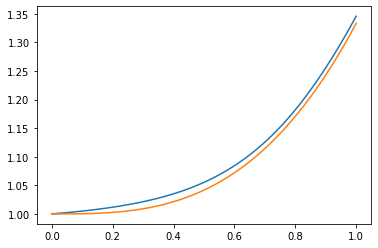

In [ ]:
# True Solution (found analitically)
%pylab inline
def true_solution(x):
  return (x**3)/3 + 1
X = np.linspace(0, 1, 100)
result = []
for i in X:
  result.append(g(i).numpy()[0][0][0])
S = true_solution(X)
plt.plot(X, result)
plt.plot(X, S)
plt.show()


In [ ]:
g(1).shape

TensorShape([1, 1])

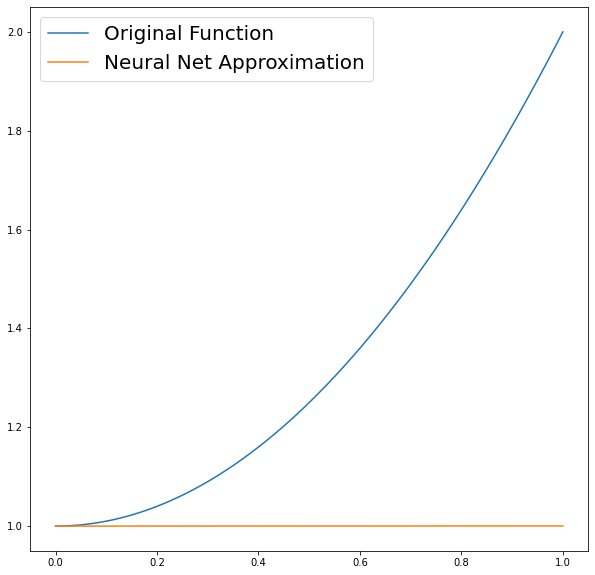

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(10,10))
# True Solution (found analitically)
def true_solution(x):
    return x**2 + 1

X = np.linspace(0, 1, 100)
result = []
for i in X:
  # result.append(f(i))
  result.append(g(i).numpy()[0][0])

S = true_solution(X)
  
plt.plot(X, S, label="Original Function")
plt.plot(X, result, label="Neural Net Approximation")
plt.legend(loc=2, prop={'size': 20})
plt.show()

In [ ]:

# @author: Maziar Raissi


import sys
sys.path.insert(0, '../../Utilities/')

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from pyDOE import lhs
import plotting
#from plotting import newfig
#from plotting import savefig
from mpl_toolkits.mplot3d import Axes3D
import time
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable


np.random.seed(1234)
tf.compat.v1.set_seed(1234)


class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, x0, u0, v0, tb, X_f, layers, lb, ub):
        
        X0 = np.concatenate((x0, 0*x0), 1) # (x0, 0)
        X_lb = np.concatenate((0*tb + lb[0], tb), 1) # (lb[0], tb)
        X_ub = np.concatenate((0*tb + ub[0], tb), 1) # (ub[0], tb)
        
        self.lb = lb
        self.ub = ub
               
        self.x0 = X0[:,0:1]
        self.t0 = X0[:,1:2]

        self.x_lb = X_lb[:,0:1]
        self.t_lb = X_lb[:,1:2]

        self.x_ub = X_ub[:,0:1]
        self.t_ub = X_ub[:,1:2]
        
        self.x_f = X_f[:,0:1]
        self.t_f = X_f[:,1:2]
        
        self.u0 = u0
        self.v0 = v0
        
        # Initialize NNs
        self.layers = layers
        self.weights, self.biases = self.initialize_NN(layers)
        
        # tf Placeholders        
        self.x0_tf = tf.placeholder(tf.float32, shape=[None, self.x0.shape[1]])
        self.t0_tf = tf.placeholder(tf.float32, shape=[None, self.t0.shape[1]])
        
        self.u0_tf = tf.placeholder(tf.float32, shape=[None, self.u0.shape[1]])
        self.v0_tf = tf.placeholder(tf.float32, shape=[None, self.v0.shape[1]])
        
        self.x_lb_tf = tf.placeholder(tf.float32, shape=[None, self.x_lb.shape[1]])
        self.t_lb_tf = tf.placeholder(tf.float32, shape=[None, self.t_lb.shape[1]])
        
        self.x_ub_tf = tf.placeholder(tf.float32, shape=[None, self.x_ub.shape[1]])
        self.t_ub_tf = tf.placeholder(tf.float32, shape=[None, self.t_ub.shape[1]])
        
        self.x_f_tf = tf.placeholder(tf.float32, shape=[None, self.x_f.shape[1]])
        self.t_f_tf = tf.placeholder(tf.float32, shape=[None, self.t_f.shape[1]])

        # tf Graphs
        self.u0_pred, self.v0_pred, _ , _ = self.net_uv(self.x0_tf, self.t0_tf)
        self.u_lb_pred, self.v_lb_pred, self.u_x_lb_pred, self.v_x_lb_pred = self.net_uv(self.x_lb_tf, self.t_lb_tf)
        self.u_ub_pred, self.v_ub_pred, self.u_x_ub_pred, self.v_x_ub_pred = self.net_uv(self.x_ub_tf, self.t_ub_tf)
        self.f_u_pred, self.f_v_pred = self.net_f_uv(self.x_f_tf, self.t_f_tf)
        
        # Loss
        self.loss = tf.reduce_mean(tf.square(self.u0_tf - self.u0_pred)) + \
                    tf.reduce_mean(tf.square(self.v0_tf - self.v0_pred)) + \
                    tf.reduce_mean(tf.square(self.u_lb_pred - self.u_ub_pred)) + \
                    tf.reduce_mean(tf.square(self.v_lb_pred - self.v_ub_pred)) + \
                    tf.reduce_mean(tf.square(self.u_x_lb_pred - self.u_x_ub_pred)) + \
                    tf.reduce_mean(tf.square(self.v_x_lb_pred - self.v_x_ub_pred)) + \
                    tf.reduce_mean(tf.square(self.f_u_pred)) + \
                    tf.reduce_mean(tf.square(self.f_v_pred))
        
        # Optimizers
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})
    
        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)
                
        # tf session
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        init = tf.global_variables_initializer()
        self.sess.run(init)
              
    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
    
    def net_uv(self, x, t):
        X = tf.concat([x,t],1)
        
        uv = self.neural_net(X, self.weights, self.biases)
        u = uv[:,0:1]
        v = uv[:,1:2]
        
        u_x = tf.gradients(u, x)[0]
        v_x = tf.gradients(v, x)[0]

        return u, v, u_x, v_x

    def net_f_uv(self, x, t):
        u, v, u_x, v_x = self.net_uv(x,t)
        
        u_t = tf.gradients(u, t)[0]
        u_xx = tf.gradients(u_x, x)[0]
        
        v_t = tf.gradients(v, t)[0]
        v_xx = tf.gradients(v_x, x)[0]
        
        f_u = u_t + 0.5*v_xx + (u**2 + v**2)*v
        f_v = v_t - 0.5*u_xx - (u**2 + v**2)*u   
        
        return f_u, f_v
    
    def callback(self, loss):
        print('Loss:', loss)
        
    def train(self, nIter):
        
        tf_dict = {self.x0_tf: self.x0, self.t0_tf: self.t0,
                   self.u0_tf: self.u0, self.v0_tf: self.v0,
                   self.x_lb_tf: self.x_lb, self.t_lb_tf: self.t_lb,
                   self.x_ub_tf: self.x_ub, self.t_ub_tf: self.t_ub,
                   self.x_f_tf: self.x_f, self.t_f_tf: self.t_f}
        
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            
            # Print
            if it % 10 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                print('It: %d, Loss: %.3e, Time: %.2f' % 
                      (it, loss_value, elapsed))
                start_time = time.time()
                                                                                                                          
        self.optimizer.minimize(self.sess, 
                                feed_dict = tf_dict,         
                                fetches = [self.loss], 
                                loss_callback = self.callback)        
                                    
    
    def predict(self, X_star):
        
        tf_dict = {self.x0_tf: X_star[:,0:1], self.t0_tf: X_star[:,1:2]}
        
        u_star = self.sess.run(self.u0_pred, tf_dict)  
        v_star = self.sess.run(self.v0_pred, tf_dict)  
        
        
        tf_dict = {self.x_f_tf: X_star[:,0:1], self.t_f_tf: X_star[:,1:2]}
        
        f_u_star = self.sess.run(self.f_u_pred, tf_dict)
        f_v_star = self.sess.run(self.f_v_pred, tf_dict)
               
        return u_star, v_star, f_u_star, f_v_star
    
if __name__ == "__main__": 
     
    noise = 0.0        
    
    # Doman bounds
    lb = np.array([-5.0, 0.0])
    ub = np.array([5.0, np.pi/2])

    N0 = 50
    N_b = 50
    N_f = 20000
    layers = [2, 100, 100, 100, 100, 2]
        
    data = scipy.io.loadmat('../Data/NLS.mat')
    
    t = data['tt'].flatten()[:,None]
    x = data['x'].flatten()[:,None]
    Exact = data['uu']
    Exact_u = np.real(Exact)
    Exact_v = np.imag(Exact)
    Exact_h = np.sqrt(Exact_u**2 + Exact_v**2)
    
    X, T = np.meshgrid(x,t)
    
    X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
    u_star = Exact_u.T.flatten()[:,None]
    v_star = Exact_v.T.flatten()[:,None]
    h_star = Exact_h.T.flatten()[:,None]
    
    ###########################
    
    idx_x = np.random.choice(x.shape[0], N0, replace=False)
    x0 = x[idx_x,:]
    u0 = Exact_u[idx_x,0:1]
    v0 = Exact_v[idx_x,0:1]
    
    idx_t = np.random.choice(t.shape[0], N_b, replace=False)
    tb = t[idx_t,:]
    
    X_f = lb + (ub-lb)*lhs(2, N_f)
            
    model = PhysicsInformedNN(x0, u0, v0, tb, X_f, layers, lb, ub)
             
    start_time = time.time()                
    model.train(50000)
    elapsed = time.time() - start_time                
    print('Training time: %.4f' % (elapsed))
    
        
    u_pred, v_pred, f_u_pred, f_v_pred = model.predict(X_star)
    h_pred = np.sqrt(u_pred**2 + v_pred**2)
            
    error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
    error_v = np.linalg.norm(v_star-v_pred,2)/np.linalg.norm(v_star,2)
    error_h = np.linalg.norm(h_star-h_pred,2)/np.linalg.norm(h_star,2)
    print('Error u: %e' % (error_u))
    print('Error v: %e' % (error_v))
    print('Error h: %e' % (error_h))

    
    U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
    V_pred = griddata(X_star, v_pred.flatten(), (X, T), method='cubic')
    H_pred = griddata(X_star, h_pred.flatten(), (X, T), method='cubic')

    FU_pred = griddata(X_star, f_u_pred.flatten(), (X, T), method='cubic')
    FV_pred = griddata(X_star, f_v_pred.flatten(), (X, T), method='cubic')     
    


AttributeError: ignored

In [ ]:
from plotting import 

ERROR: Could not find a version that satisfies the requirement newfig (from versions: none)
ERROR: No matching distribution found for newfig
